# Tutorial : Training a spiking neural network with surrogate gradients

Credit: this tutorial is modified from https://github.com/fzenke/spytorch/blob/master/notebooks/SpyTorchTutorial1.ipynb by
Friedemann Zenke (https://fzenke.net)

## Example network

Let's start with a simple multilayer feedforward network model with a single hidden layer, as shown below.

<img src="https://github.com/fzenke/spytorch/blob/master/notebooks/figures/mlp_sketch/mlp_sketch.png?raw=1">

For the sake of argument, we set the numbers for the input, hidden and output neurons as follows:

In [2]:
nb_inputs  = 100
nb_hidden  = 6
nb_outputs = 2

As we have seen above, we are technically simulating an RNN. Thus we have to simulate our neurons for a certain number of timesteps. We will use 1ms timesteps, and we want to simulate our network for say 100 timesteps. 

In [3]:
time_step = 1e-3
nb_steps  = 100

To take advantage of parallelism, we will set up our code to work on batches of data like this is usually done for neural networks that are trained in a supervised manner.
To that end, we specify a batch size here.

In [5]:
batch_size = 128

With these basic design choices made, we can now start building the actual network. Here we will be using PyTorch, but you will be able to reproduce these results in most common machine learning libraries.

We start by importing the libraries we need.

In [6]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn

In [7]:
dtype = torch.float
# device = torch.device("cpu")

# Uncomment the line below to run on GPU
device = torch.device("cuda:0") 

### A simple synthetic dataset 

We start by generating some random spiking data set, which we will use as input to our network. In the beginning, we will work with a single batch of data. It will be straight forward to expand later what we have learned to larger datasets.

Suppose we want our network to classify a set of different sparse input spike trains into two categories. 

To generate some synthetic data, we fill a tensor of (batch_size x nb_steps x nb_inputs) with random uniform numbers between 0 and 1 and use this to generate our input dataset:

In [8]:
freq = 5 # Hz
prob = freq*time_step
mask = torch.rand((batch_size,nb_steps,nb_inputs), device=device, dtype=dtype)
x_data = torch.zeros((batch_size,nb_steps,nb_inputs), device=device, dtype=dtype, requires_grad=False)
x_data[mask<prob] = 1.0

If the plot the spike raster of the first input pattern, this synthetic dataset looks as follows.

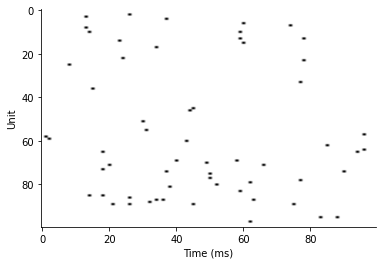

In [9]:
data_id = 0
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

Next, we assign a random label of 0 or 1 to each of our input patterns. Our network's task will be to differentiate these patterns.

In [93]:
y_data = torch.tensor(1*(np.random.rand(batch_size)<0.5), device=device)


Note that there is no structure in the data (because it is entirely random). Thus we won't worry about generalization now and only care about our ability to overfit these data with the spiking neural network we are going to build in a jiffy.

### Setup of the spiking network model

Now is the time to implement our LIF neuron model in discrete time.
We will first do this step by step before we wrap all the steps into a function later on.
But first, we fix several model constants such as the membrane and the synaptic time constant. Moreover, we define some essential variables, including $\beta$ as described above. We do this now because we will use some of these variables to scale our weights to meaningful ranges.

In [94]:
tau_mem = 10e-3

beta    = float(np.exp(-time_step/tau_mem))

Now we set up our weight matrices, which connect the input and the hidden layer, as well as the matrix connecting the hidden layer with the output layer. Moreover, we initialize these weights randomly from a normal distribution. Note that we scale the variance with the inverse square root of the number of input connections. Moreover, for the sake of simplicity, we ignore Dale's law in this tutorial. Thus weights can be either excitatory or inhibitory. This choice is prevalent in artificial neural networks.

In [95]:
weight_scale = 50*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

init done


### A spiking neuron model in discrete time

The first thing we need to do to implement our spiking neuron is to multiply all input spikes with the weight matrix. We have to do this for each time step in each input example in the batch. Because we have stored our input spikes in a rank three tensor we can express this operation in a single line:

In [96]:
h1 = torch.einsum("abc,cd->abd", (x_data, w1)) # a: batch, b: time, c: input, d: hidden

These "weighted" input spikes will now feed into our synaptic variable and, ultimately, the membrane potential. To trigger a spike, we need to define moreover a threshold or spike function, which we do in the following. We will later have to alter this definition to train the network, but more about that later.

### The spiking nonlinearity (the naive way)

In discrete-time, as explained earlier, we can formulate our spiking nonlinearity as a Heaviside step function. So let's begin with defining a Heaviside function. One way of implementing it is the following:

In [97]:
def spike_fn(x):
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    return out

For each trial, we initialize the membrane potentials at zero.
Next, we need to implement a loop that simulates our neuron models over time. 
Moreover, we will record the membrane potentials and output spikes of all trials and all neurons.

In [98]:

mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

# Here we define two lists which we use to record the membrane potentials and output spikes
mem_rec = [mem]
spk_rec = [mem]

threshold = 1

# Here we loop over time
for t in range(nb_steps):
    # TODO: Recurrent equation for the membrane potential mem (leaky integration of h1[:,t])
    # V[n+1]= βV[n]+∑wjS j[n]
    mem = beta*mem +h1[:,t]
    # TODO: Thresholding to get spk from mem (assuming a threshold of 1.0)
    # S_out[n+1]=θ(V[n+1]−Threshold)
    spk = spike_fn(mem-threshold)
    # TODO: Resetting mem
    # V[n+1]=(1−Sout[n+1]) V[n+1]
    mem = (1-spk)*mem

    mem_rec.append(mem)
    spk_rec.append(spk)

    

# Now we merge the recorded membrane potentials into a single tensor
mem_rec = torch.stack(mem_rec,dim=1)
spk_rec = torch.stack(spk_rec,dim=1)

And that's it. The above loop has now simulated our neurons for '''nb_steps''' and stored their membrane traces and output spikes. Let us take a look at those membrane potentials in which we directly "paste" the spikes for visual inspection. We will directly plot multiple trials at once and define a little helper function for this purpose.

In [99]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = (mem+spike_height*spk).detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

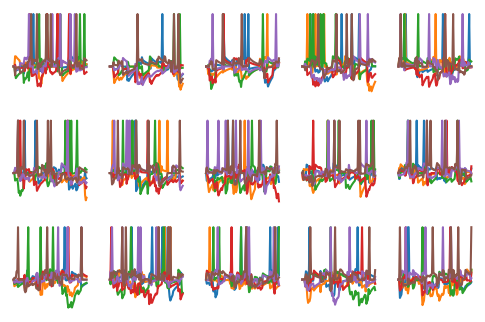

In [100]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

As you can see, our random initialization gives us some sporadic spiking. Thus far, we have only an input layer and a spiking layer, which should become our hidden layer. Next, we will have to add a readout layer to our network.

## Adding a readout layer

To use our network as a classifier, we need to have a readout layer on whose output we can define a cost function. There are several possibilities for doing this. For instance, we could count output layer spikes, or we could directly define an objective function on the membrane potential of the output neurons. Here we will follow the latter approach, but keep in mind that there are many other possibilities of defining an output layer and respective cost functions on them.

In the following, we will build the output layer as a population of leaky integrator neurons. The reason for this choice is that leaky integration is the natural way of how neurons receive the spiking output of their brethren. Moreover, because we will need this code again, we combine our code from above plus the added readout layer into a single function.

In [101]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1)) # a: batch, b: time, c: input, d: hidden
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = [mem]
    spk_rec = [mem]

    # Compute hidden layer activity
    for t in range(nb_steps):
        # TODO: Recurrent equation for the membrane potential mem (leaky integration of h1[:,t])
        # V[n+1]= βV[n]+∑wjS j[n]
        mem = beta*mem +h1[:,t]
        # TODO: Thresholding to get spk from mem (assuming a threshold of 1.0)
        # S_out[n+1]=θ(V[n+1]−Threshold)
        spk = spike_fn(mem-threshold)
        # TODO: Resetting mem
        # V[n+1]=(1−Sout[n+1]) V[n+1]
        mem = (1-spk)*mem
        
        # store history
        mem_rec.append(mem)
        spk_rec.append(spk)

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2)) # a: batch, b: time, c: hidden, d: output
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        # TODO: Recurrent equation for the membrane potential out (leaky integration of h2[:,t])
        out = beta*out +h2[:,t]
        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

We can now run this code and plot the output layer "membrane potentials" below. As desired, these potentials do not have spikes riding on them.

In [102]:
out_rec,other_recs = run_snn(x_data)

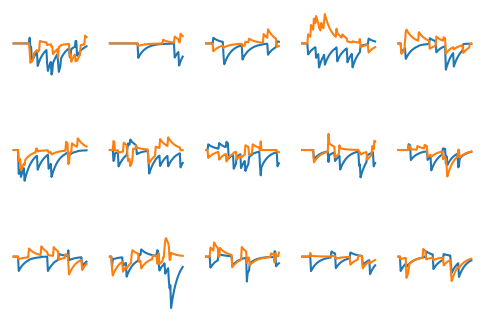

In [103]:
fig=plt.figure(dpi=100)
plot_voltage_traces(out_rec)

By preventing the output neurons from spiking themselves, we can define a relatively smooth objective on their membrane voltages directly. Specifically, we use the maximum voltage over time of each output unit
$$\hat U^\mathrm{out}_i=\max_t U^\mathrm{out}_i(t)$$
and then use this vector as input for either an argmax to compute the classification accuracy or as we will see below as input for a standard softmax function in conjunction with a negative log-likelihood loss for optimizing the weights in the network. 

Let us first compute the classification accuracy of this random network. We will see that this accuracy is somewhere around 50% as it should be since that corresponds to the chance level of our synthetic task.

In [104]:
def print_classification_accuracy():
    """ Dirty little helper function to compute classification accuracy. """
    output,_ = run_snn(x_data)
    m,_= torch.max(output,1) # max over time
    _,am=torch.max(m,1) # argmax over output units
    acc = np.mean((y_data==am).detach().cpu().numpy()) # compare to labels
    print("Accuracy %.3f"%acc)
    
print_classification_accuracy()

Accuracy 0.445


## Supervised learning

So far, we have built the infrastructure to simulate our spiking neural network, but we have worked with purely random network weights thus far.
The vanilla method to adjust network weights to decrease the specified objective is gradient descent. 
Machine learning libraries like Tensorflow and PyTorch make implementing gradient descent a breeze.
We first perform gradient descent on the correct gradient and use this as a motivation for introducing surrogate gradients.
Here we go.

### Supervised learning with the true gradient

In [105]:
from tqdm.notebook import trange

params = [w1,w2] # The paramters we want to optimize
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999)) # The optimizer we are going to use

log_softmax_fn = nn.LogSoftmax(dim=1) # The log softmax function across output units
loss_fn = nn.NLLLoss() # The negative log likelihood loss function

# The optimization loop
loss_hist_true_grad = [] # store loss for later use
for e in trange(1000, desc="training"):
    # run the network and get output
    output,_ = run_snn(x_data) 
    # compute the loss
    m,_=torch.max(output,1)
    log_p_y = log_softmax_fn(m) 
    loss_val = loss_fn(log_p_y, y_data)

    # update the weights
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    
    # store loss value
    loss_hist_true_grad.append(loss_val.item())


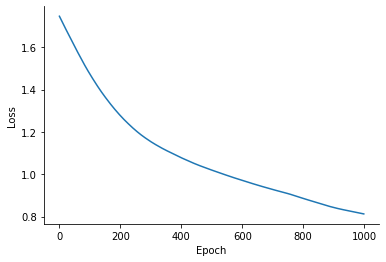

In [106]:
plt.plot(loss_hist_true_grad)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [107]:
print_classification_accuracy()

Accuracy 0.531


We appreciate that loss decreases over iterations and converges towards a steady state. The classification accuracy, however, does not seem to improve dramatically throughout the optimization. What a shame! 

The underlying reason is that the nonlinearity of the hidden units have zero derivatives everywhere except at threshold crossings, where they become infinite. In practice that means that weight updates in the hidden layer vanish and the weights remain unmodified. By plotting the hidden layer activations and comparing them with what we have plotted before, we will see that these activations have not changed at all. Thus no learning happens in the hidden layer. The reason why the loss decreased initially during optimization is that the output layer weights could still change and allow for some improvement (even if it was very little).

To improve performance, we need to get the hidden layer units to take part in learning. To achieve this, we will introduce a surrogate gradient in the next section.

In [108]:
output,other_recordings = run_snn(x_data)
mem_rec, spk_rec = other_recordings

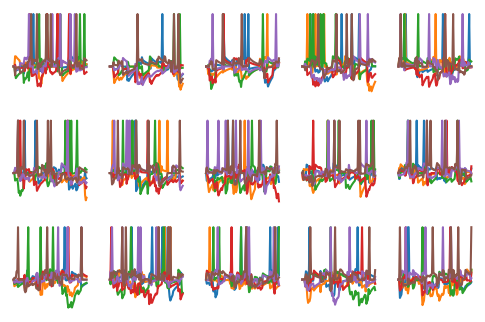

In [109]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

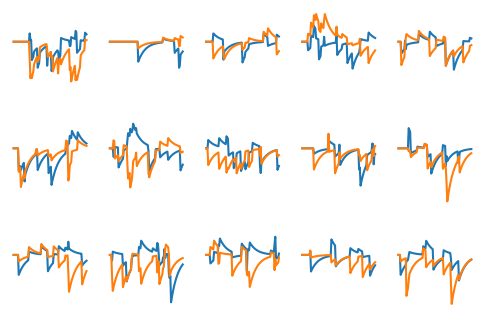

In [110]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

### Supervised learning with surrogate gradients

In the last section, we saw that the hidden layer units did not participate.
The underlying reason is that the partial derivative of the step function we used has a vanishing derivative everywhere (except at zero where it becomes infinite).

Most conventional neural networks avoid this problem by choosing a nonlinearity with non-zero partial derivative. For instance, sigmoidal or tanh units were standard during the beginnings of neural networks research. Today, ReLUs are more common. Importantly, all these activation functions have substantial non-zero support, which allows gradients to flow (to a greater or lesser extent).

What do we if we want to stick to our binary nonlinearity? There have been several approaches to tackle this problem. Here we use one such strategy which has been applied successfully to spiking neural networks: We use a surrogate gradient approach.

The idea behind a surrogate gradient is dead simple. Instead of changing the nonlinearity itself, we only change the gradient. Thus we use a different "surrogate" gradient to optimize parameters that would otherwise have a vanishing gradient.

<img src="https://github.com/fzenke/spytorch/blob/master/notebooks/figures/surrgrad/surrgrad.png?raw=1" width="450">
Specifically, we use the partial derivative of a function which to some extent approximates the stepfunction $\Theta(x)$.
In what follows, chiefly, we will use (up to rescaling) the partial derivative of a fast sigmoid function $\sigma(x)$. 
While $\Theta$ is invariant to multiplicative rescaling, $\sigma$ isn't. Thus we have to introduce a scale parameter.

In [111]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [112]:
# The following lines will reinitialize the weights
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
print("init done")

init done


In [113]:
from tqdm.notebook import trange

params = [w1,w2]
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999))

log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

loss_hist = []
for e in trange(1000, desc="training"):
    output,_ = run_snn(x_data)
    m,_=torch.max(output,1)
    log_p_y = log_softmax_fn(m)
    loss_val = loss_fn(log_p_y, y_data)

    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    loss_hist.append(loss_val.item())

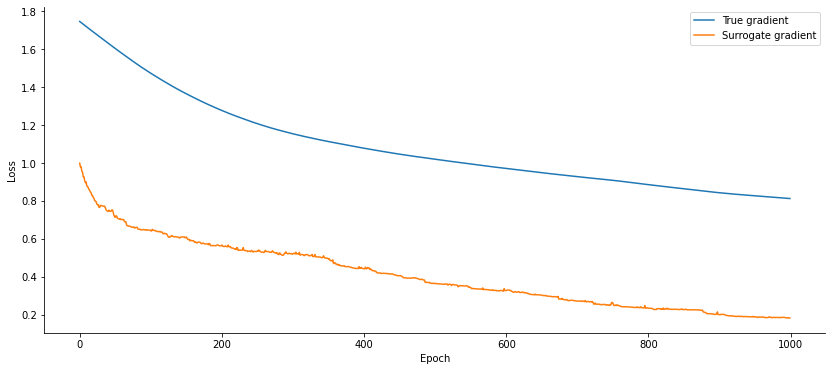

In [114]:
plt.figure(figsize=(14,6))
plt.plot(loss_hist_true_grad, label="True gradient")
plt.plot(loss_hist, label="Surrogate gradient")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
sns.despine()

In [115]:
print_classification_accuracy()


Accuracy 0.930


In [116]:
output,other_recordings = run_snn(x_data)
mem_rec, spk_rec = other_recordings

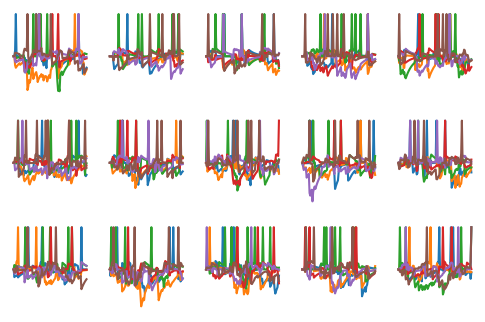

In [117]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

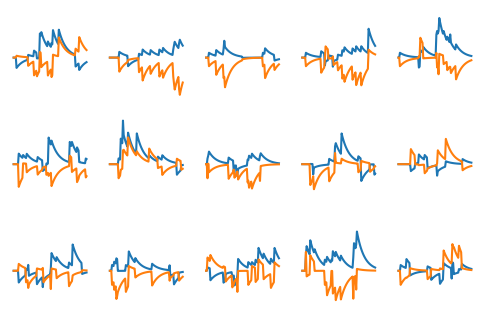

In [118]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

TODO: try to predict the impact of increasing nb_inputs, nb_hidden, nb_steps or batch_size on the accuracy, and run the code to check whether your intuition is true.

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.